# Modeling

Set up training data w/ McAuley's Steam Review Dataset (do an 80-20 split).  

I want to test the original data-trained model on the original data and the new data.  
I want to test the new data-trained model on the original data and the new data.  

## Goal
I want to predict whether or not an item should be placed in the same bundle.  
My idea is that if you are creating a bundle you should be able to narrow down your choice of candidates to the most relevant bundle items (maybe this can in fact be nearly any game depending on what games are allowed to be bundled, but in general this is not the case). Most bundles are intentional. If you bundle a game your goal is to increase sales (otherwise you would give away the game for free or would heavily discount that game exclusively, presumably).  

Price was considered as a variable, however, this is too constraining. With summer/winter/flash sales this becomes inconsistent (e.g. the full price may be intentionally marked high to make these sales look significantly better). This creates an unnecessary constraint. What matters is the game combination. 
  
I will use genre for OHE.  
Try latent factor models.  
Try SVD.  

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

In [2]:
old_bundle_fp = Path("data") / "old_bundle.csv"
obun = pd.read_csv(old_bundle_fp)
obun.head(3)

,bundle_id,item_name,genre
0,696,Techwars Online,"['Action', 'Indie', 'Massively Multiplayer', '..."
1,696,Techwars online - Original Soundtrack,"['Action', 'Indie', 'Massively Multiplayer', '..."
2,696,Techwars online - Art book,"['Action', 'Indie', 'Massively Multiplayer', '..."


# Baseline Model (5 Fold CV Logistic Regression)

In [3]:
obun_groups = obun.groupby("bundle_id")
train_data, test_data = list(), list()

N = len(obun_groups)

train_ids = set()
i = 0
for curr_bundle_id, curr_bundle in obun_groups:
    train_ids.add(curr_bundle_id)
    curr_bundle["label"] = 1
    n = len(curr_bundle)
    negative_data = obun.query("bundle_id in @train_ids").sample(10*n, replace=True) # don't sample test data
    negative_data = negative_data.query("bundle_id != @curr_bundle_id")
    negative_data["label"] = 0
    curr_bundle["compare_id"] = i
    negative_data["compare_id"] = i
    comb = pd.concat((negative_data, curr_bundle))

    if i > 0.8 * N:
        test_data.append(comb)
    else:
        train_data.append(comb)

    i += 1


len(train_data), len(test_data), len(train_data) + len(test_data) == 308

(247, 61, True)

In [4]:
train = pd.concat(train_data)
test = pd.concat(test_data)

train.shape, test.shape

((11815, 5), (4918, 5))

In [5]:
train.to_csv("colab/train.csv", index=False)
test.to_csv("colab/test.csv", index=False)

In [6]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(handle_unknown="ignore")
ohe.fit(train["genre"].to_frame())

,categories,'auto'
,drop,None
,sparse_output,True
,dtype,<class 'numpy.float64'>
,handle_unknown,'ignore'
,min_frequency,None
,max_categories,None
,feature_name_combiner,'concat'


In [7]:
X_train = ohe.transform(train["genre"].to_frame())
y_train = train["label"].to_numpy()
X_test = ohe.transform(test["genre"].to_frame())
y_test = test["label"].to_numpy()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((11815, 128), (11815,), (4918, 128), (4918,))

In [8]:
from sklearn.linear_model import LogisticRegressionCV

log_reg = LogisticRegressionCV(cv=5)
log_reg.fit(X_train, y_train)

,Cs,10
,fit_intercept,True
,cv,5
,dual,False
,penalty,'l2'
,scoring,None
,solver,'lbfgs'
,tol,0.0001
,max_iter,100
,class_weight,None
,n_jobs,None


In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_train, y_train_probs, y_test, y_test_probs, title=None):
    """
    Plots ROC curves for both Train and Test sets.
    
    Args:
        y_train: Ground truth labels for training set.
        y_train_probs: Probability of positive class for training set.
        y_test: Ground truth labels for test set.
        y_test_probs: Probability of positive class for test set.
    """
    plt.figure(figsize=(10, 6))
    
    # --- Data Sets to Plot ---
    datasets = [
        (y_train, y_train_probs, 'Train', 'blue'),
        (y_test, y_test_probs, 'Test', 'orange')
    ]
    
    for y_true, y_prob, label, color in datasets:
        # Calculate FPR, TPR, and Thresholds
        fpr, tpr, thresholds = roc_curve(y_true, y_prob)
        
        # Calculate Area Under Curve (AUC)
        roc_auc = auc(fpr, tpr)
        
        # Plot
        plt.plot(fpr, tpr, color=color, lw=2, 
                 label=f'{label} ROC (AUC = {roc_auc:.3f})')
    
    # --- Plot Formatting ---
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    if title is not None:
        plt.title(f'ROC Curve ({title})')
    else:
        plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

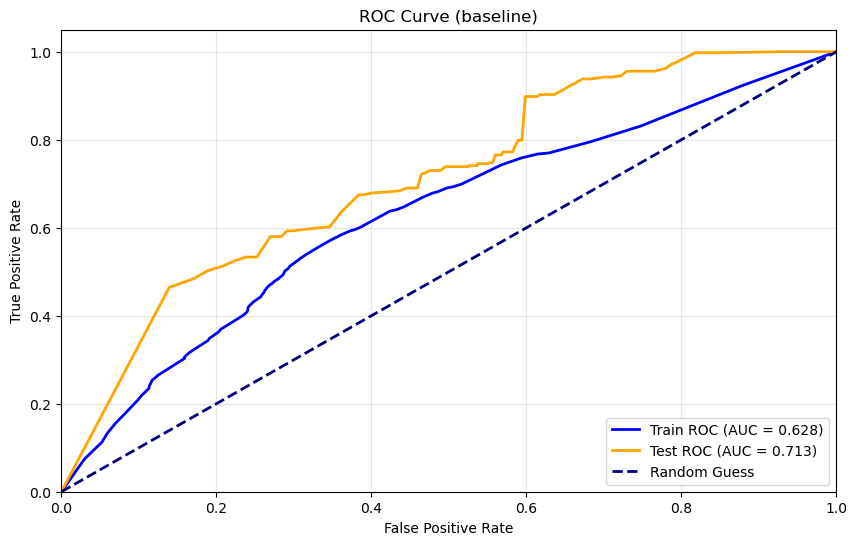

In [10]:
y_train_probs = log_reg.predict_proba(X_train)[:, 1]
y_test_probs = log_reg.predict_proba(X_test)[:, 1]

plot_roc_curve(y_train, y_train_probs, y_test, y_test_probs, title="baseline")

In [11]:
def get_accuracy(y_preds, y_true):
    zero_acc = ((y_preds == 0) & (y_true == 0)).sum() / (y_true == 0).sum()
    ones_acc = ((y_preds == 1) & (y_true == 1)).sum() / (y_true == 1).sum()
    overall_acc = (y_preds == y_true).sum() / len(y_true)

    print(f"Negative Accuracy = {zero_acc:.4f}")
    print(f"Positive Accuracy = {ones_acc:.4f}")
    print(f"Overall Accuracy = {overall_acc:.4f}")

    return zero_acc, ones_acc, overall_acc

In [12]:
train_preds = log_reg.predict(X_train)
get_accuracy(train_preds, y_train); # model ends up only predicting False because 10/11 items are False in the training set

Negative Accuracy = 1.0000
Positive Accuracy = 0.0000
Overall Accuracy = 0.9039


In [13]:
test_preds = log_reg.predict(X_test)
get_accuracy(test_preds, y_test); # model ends up only predicting False because 10/11 items are False in the training set

Negative Accuracy = 1.0000
Positive Accuracy = 0.0000
Overall Accuracy = 0.9081


# Custom Model

In [14]:
from sklearn.model_selection import GridSearchCV

In [15]:
weights = {
    0: 1,
    1: 10
}

params = {
    "class_weight": [
        {0: 1, 1: 2**k} for k in range(3)
    ] + ["balanced"]
}

model = LogisticRegressionCV()
# log_reg = LogisticRegressionCV(cv=5, class_weight=weights)
log_reg = GridSearchCV(model, param_grid=params, scoring="f1")
log_reg.fit(X_train, y_train)

,estimator,LogisticRegressionCV()
,param_grid,"{'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2}, ...]}"
,scoring,'f1'
,n_jobs,None
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,Cs,10


In [16]:
test_preds = log_reg.predict(X_test)
get_accuracy(test_preds, y_test)

Negative Accuracy = 0.4133
Positive Accuracy = 0.8717
Overall Accuracy = 0.4555


(np.float64(0.41334527541424093),
 np.float64(0.8716814159292036),
 np.float64(0.4554697031313542))

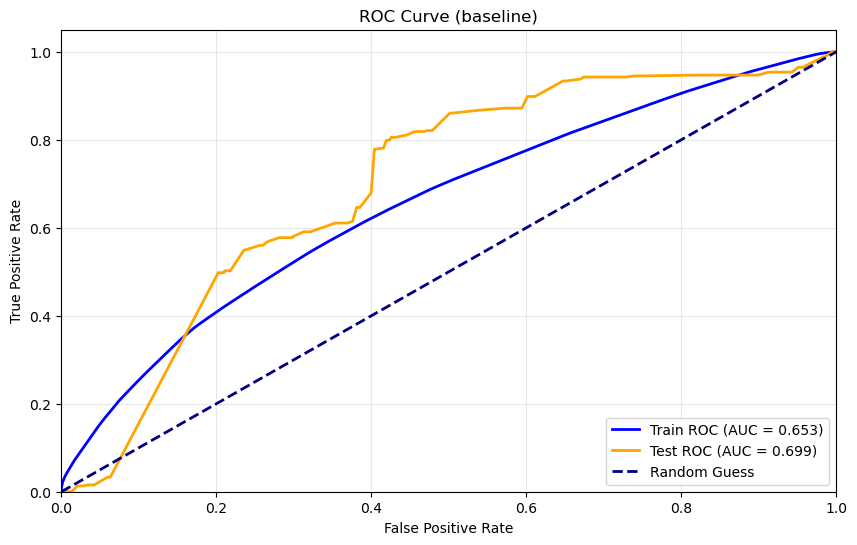

In [17]:
y_train_probs = log_reg.predict_proba(X_train)[:, 1]
y_test_probs = log_reg.predict_proba(X_test)[:, 1]

plot_roc_curve(y_train, y_train_probs, y_test, y_test_probs, title="baseline")

In [18]:
from scipy import sparse

sparse.save_npz("colab/X_train.npz", X_train)
np.save("colab/y_train.npy", y_train)
sparse.save_npz("colab/X_test.npz", X_test)
np.save("colab/y_test.npy", y_test)